# Importing libraries and setting up the environment

Before we dive into the analysis and modeling, we start by importing all the necessary Python libraries.

1. **Data handling**
    - `pandas` and `numpy` for loading and manipulating datasets.

2. **Visualization**
    - `matplotlib` and `seaborn` to create plots and explore data distributions.

3. **Machine learning**
    - `scikit-learn` for implementing various classification algorithms,
      preprocessing data, and evaluating model performance.

We also set a random seed to make sure our experiments are reproducible.


In [10]:
from IPython.core.pylabtools import figsize
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import sklearn.preprocessing as skl_pre
from sklearn.model_selection import train_test_split
import sklearn.linear_model as skl_lm
import sklearn.discriminant_analysis as skl_da
import sklearn.neighbors as skl_nb
import sklearn.model_selection as skl_ms
from sklearn.ensemble import RandomForestClassifier

pd.options.mode.chained_assignment = None
np.random.seed(1)


# Loading the data

We start by loading the training and test datasets using `pandas`. This gives us an initial idea of the dataset size and structure.


In [11]:
# Read data
train = pd.read_csv('../data/train.csv')
print(train.shape)
test = pd.read_csv('../data/test.csv')


(1039, 14)


# Feature engineering

To prepare our data for modeling, we create a few new features:

- **Co-lead words**: estimates the words spoken by the co-lead as a proportion of total words.
- **Percentage of words spoken by female and male actors**: normalizes the dialogue counts.

We also drop the columns `Total words` and `Difference in words lead and co-lead` since their information is now captured in the new features.
We apply the same transformations to both the training and test datasets.


In [12]:
### Feature selection and engineering ###

train["Co-lead words"] = (
    (train["Number of words lead"] - train["Difference in words lead and co-lead"]) 
    / train["Total words"]
)
train["percentage female"] = train["Number words female"] / train["Total words"]
train["percentage male"] = train["Number words male"] / train["Total words"]

train = train.drop(["Difference in words lead and co-lead", "Total words"], axis=1)

# Apply the same transformations to the test data
test["Co-lead words"] = (
    (test["Number of words lead"] - test["Difference in words lead and co-lead"])
    / test["Total words"]
)
test["percentage female"] = test["Number words female"] / test["Total words"]
test["percentage male"] = test["Number words male"] / test["Total words"]

test = test.drop(["Difference in words lead and co-lead", "Total words"], axis=1)

X = train.drop("Lead", axis=1)
y = train["Lead"]


# Finding the optimal *k* for k-Nearest Neighbors

To tune our k-NN model, we run multiple cross-validation loops over a range of *k* values (from 1 to 200).
This helps us understand how the choice of *k* affects prediction accuracy.

We repeat this process several times to get a stable estimate, then plot the average accuracy
to identify the best *k* value for our dataset.


c:\Users\ramin\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\ramin\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

The optimal k is 14 with an average accuracy of 0.8878


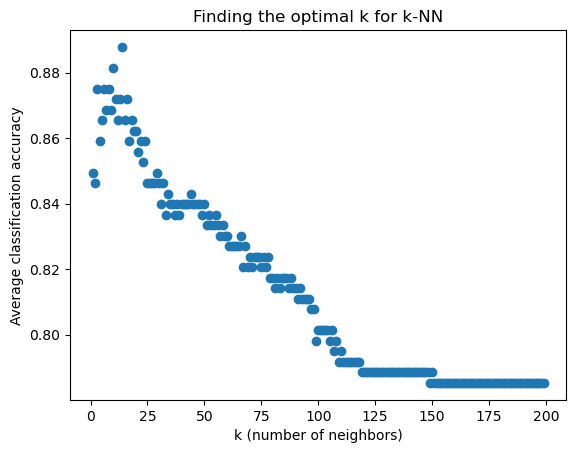

In [14]:
### KNN METHOD ###
# Cross-validation with repeated splitting to find the optimal k

n_runs = 10
K = np.arange(1, 200)
classification = np.zeros((n_runs, len(K)))

for i in range(n_runs):
    x_train, x_val, y_train, y_val = skl_ms.train_test_split(
        X, y, test_size=0.3, random_state=1
    )
    
    # Rescale data with Standard Scaler
    scaler = skl_pre.StandardScaler().fit(x_train)
    
    for j, k in enumerate(K):
        model = skl_nb.KNeighborsClassifier(n_neighbors=k)
        model.fit(scaler.transform(x_train), y_train)
        prediction = model.predict(scaler.transform(x_val))
        classification[i, j] = np.mean(prediction == y_val)

average_classification = np.mean(classification, axis=0)

optimal_k_index = np.argmax(average_classification)
optimal_k = K[optimal_k_index]
optimal_accuracy = average_classification[optimal_k_index]

print(f"The optimal k is {optimal_k} with an average accuracy of {optimal_accuracy:.4f}")

plt.scatter(K, average_classification)
plt.xlabel("k (number of neighbors)")
plt.ylabel("Average classification accuracy")
plt.title("Finding the optimal k for k-NN")
plt.show()



# Tuning Random Forest hyperparameters

Next, we tune the hyperparameters of the Random Forest classifier to improve its performance.
We use `GridSearchCV` to explore different values for:

- `n_estimators`: the number of trees in the forest.
- `max_leaf_nodes`: the maximum number of leaf nodes in each tree.

We use 5-fold cross-validation to evaluate the performance of each parameter combination and
print out the best configuration along with its cross-validated accuracy score.


In [15]:
# Random Forest hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': list(range(10, 100, 10)),
    'max_leaf_nodes': list(range(10, 100, 10)),
    'random_state': [1]
}

grid_search = skl_ms.GridSearchCV(
    RandomForestClassifier(),
    param_grid,
    cv=5,
    scoring='accuracy',
    return_train_score=True
)

grid_search.fit(X, y)

print("Best parameters found:", grid_search.best_params_)
print(f"Best cross-validated accuracy: {grid_search.best_score_:.4f}")


Best parameters found: {'max_leaf_nodes': 90, 'n_estimators': 60, 'random_state': 1}
Best cross-validated accuracy: 0.8980


# Comparing different models with k-fold cross-validation

To understand how our selected models perform relative to each other, we run a k-fold cross-validation 
process (with 5 folds) and calculate the validation error for each model. This gives us a clearer picture 
of which models are more stable and accurate on unseen data.

We include:

- Quadratic Discriminant Analysis (QDA)
- k-Nearest Neighbors with the optimal *k* we found
- Random Forest with tuned hyperparameters

Finally, we plot a boxplot of the validation errors for each model to visualize their performance spread.


c:\Users\ramin\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\ramin\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

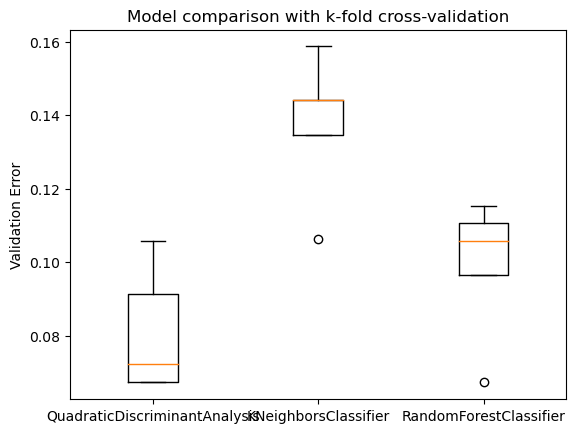

In [16]:
# Define the models to compare
models = []
models.append(skl_da.QuadraticDiscriminantAnalysis())
models.append(skl_nb.KNeighborsClassifier(n_neighbors=optimal_k))
models.append(RandomForestClassifier(
    n_estimators=grid_search.best_params_['n_estimators'],
    max_leaf_nodes=grid_search.best_params_['max_leaf_nodes'],
    random_state=1
))

# k-fold cross-validation
n_fold = 5
misclassification = np.zeros((n_fold, len(models)))
cv = skl_ms.KFold(n_splits=n_fold, random_state=2, shuffle=True)

for i, (train_index, val_index) in enumerate(cv.split(X)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    for j, model in enumerate(models):
        scaler = skl_pre.StandardScaler().fit(X_train)
        model.fit(scaler.transform(X_train), y_train)
        prediction = model.predict(scaler.transform(X_val))
        misclassification[i, j] = np.mean(prediction != y_val)

# Boxplot to compare validation errors
plt.boxplot(misclassification)
plt.xticks(np.arange(len(models)) + 1, [type(model).__name__ for model in models])
plt.ylabel("Validation Error")
plt.title("Model comparison with k-fold cross-validation")
plt.show()
